In [1]:
import cv2
import numpy as np
import torch
import pyiqa
import torchvision.transforms as transforms
import torchvision.models as models
from skimage.metrics import structural_similarity as ssim
from PIL import Image
import pytesseract
import logging
import os
import math

# Optional: Set path for Tesseract if needed
# pytesseract.pytesseract.tesseract_cmd = r'C:\Program Files\Tesseract-OCR\tesseract.exe'

logging.basicConfig(level=logging.INFO)

class ImageAnalyzer:
    def __init__(self):
        self.brisque_model = pyiqa.create_metric('brisque', device='cpu')
        self.niqe_model = pyiqa.create_metric('niqe', device='cpu')
        self.piqe_model = pyiqa.create_metric('piqe', device='cpu')
        self.model = models.resnet50(pretrained=True)
        self.model.eval()
        self.transform = transforms.Compose([
            transforms.Resize((224, 224)),
            transforms.ToTensor(),
            transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        ])

    def compute_entropy(self, gray):
        hist = cv2.calcHist([gray], [0], None, [256], [0, 256])
        hist_norm = hist.ravel() / hist.sum()
        hist_norm = hist_norm[hist_norm > 0]
        return -np.sum(hist_norm * np.log2(hist_norm))

    def compute_colorfulness_index(self, image):
        (B, G, R) = cv2.split(image.astype("float"))
        rg = np.absolute(R - G)
        yb = np.absolute(0.5 * (R + G) - B)
        std_rg, std_yb = np.std(rg), np.std(yb)
        mean_rg, mean_yb = np.mean(rg), np.mean(yb)
        return np.sqrt(std_rg**2 + std_yb**2) + 0.3 * np.sqrt(mean_rg**2 + mean_yb**2)

    def compute_edge_density(self, gray):
        edges = cv2.Canny(gray, 100, 200)
        return np.count_nonzero(edges) / edges.size

    def compute_exposure_metric(self, gray):
        hist = cv2.calcHist([gray], [0], None, [256], [0, 256])
        hist /= hist.sum()
        exposure_balance = abs(np.argmax(hist) - 128)
        return 128 - exposure_balance

    def compute_metrics(self, image):
        if image is None:
            raise ValueError("❌ Error: Image is None.")

        img_pil = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        img_tensor = torch.tensor(np.array(img_pil)).float().div(255.0).permute(2, 0, 1).unsqueeze(0)

        brisque_score = self.brisque_model(img_tensor).item()
        niqe_score = self.niqe_model(img_tensor).item()
        piqe_score = self.piqe_model(img_tensor).item()

        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        sharpness = cv2.Laplacian(gray, cv2.CV_64F).var()
        contrast = np.std(image)
        noise = np.std(gray)
        edges = cv2.Canny(gray, 100, 200)
        artifacts = np.mean(edges > 0)
        ssim_score = ssim(gray, gray)
        dynamic_range = np.max(image) - np.min(image)
        color_depth = 8 * image.shape[2] if len(image.shape) == 3 else 8

        entropy = self.compute_entropy(gray)
        colorfulness = self.compute_colorfulness_index(image)
        edge_density = self.compute_edge_density(gray)
        exposure_metric = self.compute_exposure_metric(gray)

        return {
            'brisque': brisque_score,
            'niqe': niqe_score,
            'piqe': piqe_score,
            'sharpness': sharpness,
            'contrast': contrast,
            'noise': noise,
            'artifacts': artifacts,
            'ssim': ssim_score,
            'dynamic_range': dynamic_range,
            'color_depth': color_depth,
            'entropy': entropy,
            'colorfulness': colorfulness,
            'edge_density': edge_density,
            'exposure': exposure_metric
        }

    def calculate_ips(self, metrics, category):
        base_weights = {
            "sharpness": 0.10, "contrast": 0.10, "noise": 0.08, "artifacts": 0.05,
            "ssim": 0.10, "dynamic_range": 0.08, "color_depth": 0.05,
            "entropy": 0.08, "colorfulness": 0.08, "edge_density": 0.08, "exposure": 0.05
        }

        quality_factor = (100 - metrics['brisque']) * 0.005 + (100 - metrics['niqe']) * 0.003 + (100 - metrics['piqe']) * 0.002

        if category == "portrait":
            base_weights["sharpness"] += 0.05
            base_weights["ssim"] += 0.05
            base_weights["colorfulness"] += 0.05
        elif category == "landscape":
            base_weights["contrast"] += 0.05
            base_weights["dynamic_range"] += 0.05
            base_weights["edge_density"] += 0.05
        elif category == "low_light":
            base_weights["noise"] += 0.05
            base_weights["exposure"] += 0.05
        elif category == "document":
            base_weights["sharpness"] += 0.05
            base_weights["entropy"] += 0.05

        total_weight = sum(base_weights.values())
        base_weights = {k: v / total_weight for k, v in base_weights.items()}

        ips = sum(base_weights[k] * (metrics[k] / (1 + abs(metrics[k]))) for k in base_weights)
        return round(ips * 100 * quality_factor, 2)

# ---------- Classification Functions ----------

def classify_image(image_path):
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError("❌ Image not found or unable to load.")

    if is_document(image):
        return "document"

    if is_grayscale(image):
        return classify_grayscale(image)
    else:
        return classify_color(image)

def is_document(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    mean_brightness = np.mean(gray)

    try:
        ocr_text = pytesseract.image_to_string(image)
        char_count = len(ocr_text.strip())
        ocr_confidence = char_count / (gray.shape[0] * gray.shape[1])
        if ocr_confidence > 0.00001 and mean_brightness > 80:
            return True
    except Exception as e:
        logging.warning(f"OCR printed failed: {str(e)}")

    try:
        clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8, 8))
        enhanced = clahe.apply(gray)
        _, thresh = cv2.threshold(enhanced, 0, 255, cv2.THRESH_BINARY + cv2.THRESH_OTSU)
        dilated = cv2.dilate(thresh, np.ones((3, 3), np.uint8), iterations=1)
        ocr_text = pytesseract.image_to_string(dilated)
        char_count = len(ocr_text.strip())
        ocr_confidence = char_count / (gray.shape[0] * gray.shape[1])
        if ocr_confidence > 0.00001 and mean_brightness > 80:
            return True
    except Exception as e:
        logging.warning(f"OCR handwritten failed: {str(e)}")

    return False

def is_grayscale(image):
    if len(image.shape) == 2:
        return True
    diff1 = np.mean(np.abs(image[:, :, 0] - image[:, :, 1]))
    diff2 = np.mean(np.abs(image[:, :, 1] - image[:, :, 2]))
    return diff1 < 5 and diff2 < 5

def classify_grayscale(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) if len(image.shape) == 3 else image
    mean = np.mean(gray)
    std = np.std(gray)
    if mean < 50 or std < 20:
        return "low_light"
    return "landscape"

def classify_color(image):
    skin_percent = calculate_skin_percentage(image)
    if skin_percent > 20:
        return "portrait"
    green_percent, blue_percent = calculate_natural_color_percentages(image)
    if (green_percent > 20 or blue_percent > 15) and detect_horizon(image):
        return "landscape"
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    if np.mean(gray) < 80:
        return "low_light"
    return "landscape"

def calculate_skin_percentage(image):
    ycbcr = cv2.cvtColor(image, cv2.COLOR_BGR2YCrCb)
    mask = cv2.inRange(ycbcr, np.array([0, 135, 85]), np.array([255, 180, 135]))
    return (np.count_nonzero(mask) / (image.shape[0] * image.shape[1])) * 100

def calculate_natural_color_percentages(image):
    hsv = cv2.cvtColor(image, cv2.COLOR_BGR2HSV)
    green_mask = cv2.inRange(hsv, (30, 40, 40), (75, 255, 255))
    blue_mask = cv2.inRange(hsv, (100, 40, 40), (150, 255, 255))
    green = (np.count_nonzero(green_mask) / (image.shape[0] * image.shape[1])) * 100
    blue = (np.count_nonzero(blue_mask) / (image.shape[0] * image.shape[1])) * 100
    return green, blue

def detect_horizon(image):
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    edges = cv2.Canny(gray, 50, 150, apertureSize=3)
    lines = cv2.HoughLinesP(edges, 1, np.pi / 180, threshold=100, minLineLength=100, maxLineGap=10)
    if lines is not None:
        for line in lines:
            x1, y1, x2, y2 = line[0]
            if abs(y1 - y2) < 10:
                return True
    return False

# ---------- MAIN FUNCTION ----------

image_path = input("Enter the image path: ").strip()
image = cv2.imread(image_path)
if image is None:
    print("❌ Error: Could not load image.")


category = classify_image(image_path)
analyzer = ImageAnalyzer()
metrics = analyzer.compute_metrics(image)
ips_score = analyzer.calculate_ips(metrics, category)

print(f"\n=== Category: {category.upper()} ===")
for key, value in metrics.items():
    print(f"{key.capitalize():15}: {value:.2f}")
print(f"\n✅ Image Purity Score (IPS): {ips_score}/100")

Enter the image path:  mountain.jpg


2025-04-25 10:43:20,914 INFO: Network [BRISQUE] is created.
2025-04-25 10:43:20,919 INFO: Metric [BRISQUE] is created.
2025-04-25 10:43:21,305 INFO: Network [NIQE] is created.
2025-04-25 10:43:21,305 INFO: Metric [NIQE] is created.
2025-04-25 10:43:21,315 INFO: Network [PIQE] is created.
2025-04-25 10:43:21,318 INFO: Metric [PIQE] is created.
C:\Users\welco\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
C:\Users\welco\AppData\Local\Programs\Python\Python312\Lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-d


=== Category: LANDSCAPE ===
Brisque        : 3.89
Niqe           : 2.70
Piqe           : 15.06
Sharpness      : 372.18
Contrast       : 57.52
Noise          : 51.28
Artifacts      : 0.05
Ssim           : 1.00
Dynamic_range  : 255.00
Color_depth    : 24.00
Entropy        : 7.35
Colorfulness   : 41.10
Edge_density   : 0.05
Exposure       : 70.00

✅ Image Purity Score (IPS): 71.5/100


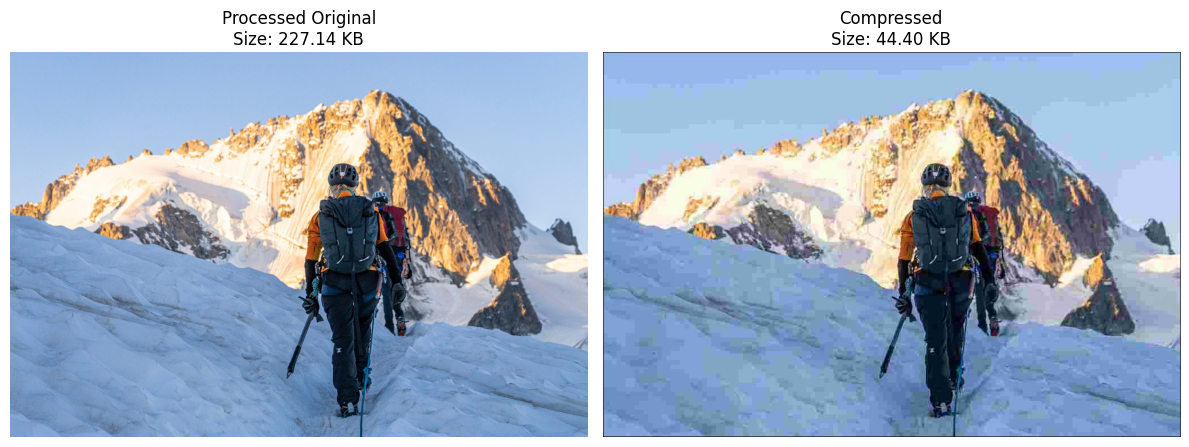

Original dimensions: 853x1280
Processed dimensions: 682x1024
Disk size of original image: 271.14 KB
Resized image size (JPEG, quality=95): 227.14 KB
Compressed image size: 44.40 KB
Compressed image saved at: C:\Users\welco\Downloads\compressed_mountain.jpg


In [2]:
import numpy as np
from PIL import Image
import io
import os
import cv2
from scipy.ndimage import sobel
from skimage.metrics import structural_similarity as ssim
import matplotlib.pyplot as plt

# Constants
TARGET_SIZE_MIN = 20 * 1024  # 20 KB in bytes
TARGET_SIZE_MAX = 50 * 1024  # 50 KB in bytes
TILE_SIZE = 256
OVERLAP = 32
QUALITY_RANGE = range(10, 101, 10)  # Quality settings from 10 to 100, step 10
MAX_DIMENSION = 1024

# Function to get the fixed path where the images will be saved
def get_fixed_save_path():
    """Get the fixed path where images will be saved."""
    save_directory = r"C:\Users\welco\Downloads"  # Fixed save directory
    if not os.path.exists(save_directory):
        os.makedirs(save_directory)  # Ensure the directory exists
    return save_directory

def edge_density(tile):
    """Compute edge density using Sobel filter."""
    gray = cv2.cvtColor(tile, cv2.COLOR_RGB2GRAY)
    edges_x = sobel(gray, axis=0)
    edges_y = sobel(gray, axis=1)
    edge_magnitude = np.sqrt(edges_x**2 + edges_y**2)
    return np.mean(edge_magnitude)

def compress_tile(tile, quality):
    """Compress a tile to JPEG at a given quality, return size and data."""
    img = Image.fromarray(tile)
    buffer = io.BytesIO()
    img.save(buffer, format="JPEG", quality=quality)
    size = buffer.tell()
    compressed_img = np.array(Image.open(buffer).convert('RGB'))
    buffer.close()
    return size, compressed_img

def compute_ssim(original, compressed):
    """Compute SSIM between original and compressed tile."""
    gray_orig = cv2.cvtColor(original, cv2.COLOR_RGB2GRAY)
    gray_comp = cv2.cvtColor(compressed, cv2.COLOR_RGB2GRAY)
    return ssim(gray_orig, gray_comp, data_range=255)

def segment_image(image, tile_size=TILE_SIZE, overlap=OVERLAP):
    """Segment image into overlapping tiles, covering the entire image."""
    h, w = image.shape[:2]
    step = tile_size - overlap
    tiles = []
    positions = []
    
    y_steps = max(1, (h - tile_size + step - 1) // step)
    x_steps = max(1, (w - tile_size + step - 1) // step)
    
    for i in range(y_steps + 1):
        y = min(i * step, h - tile_size)
        if y < 0: continue
        for j in range(x_steps + 1):
            x = min(j * step, w - tile_size)
            if x < 0: continue
            tile = image[y:y + tile_size, x:x + tile_size]
            tiles.append(tile)
            positions.append((y, x))
    
    return tiles, positions

def precompute_tile_data(tile):
    """Precompute size and distortion for each quality setting."""
    data = []
    for q in QUALITY_RANGE:
        size, compressed = compress_tile(tile, q)
        distortion = 1 - compute_ssim(tile, compressed)
        data.append((q, size, distortion))
    return data

def optimize_quality(tiles_data, target_size):
    """Optimize quality settings using Lagrangian multiplier."""
    n_tiles = len(tiles_data)
    lambda_val = 1.0
    step = 0.5
    max_iterations = 50

    for _ in range(max_iterations):
        total_size = 0
        qualities = []
        for tile_data in tiles_data:
            best_q, best_cost = None, float('inf')
            for q, size, distortion in tile_data:
                cost = distortion + lambda_val * size
                if cost < best_cost:
                    best_cost = cost
                    best_q = q
            qualities.append(best_q)
            total_size += next(s for q, s, _ in tile_data if q == best_q)

        if TARGET_SIZE_MIN <= total_size <= TARGET_SIZE_MAX:
            return qualities
        elif total_size < TARGET_SIZE_MIN:
            lambda_val -= step
        else:
            lambda_val += step
        step /= 2
    
    # Fallback: assign qualities based on importance
    importance = [max([d[2] for d in td]) for td in tiles_data]
    norm_imp = np.array(importance) / max(importance)
    return [int(40 + 50 * imp) for imp in norm_imp]

def create_alpha_mask(tile_size, overlap):
    """Create an alpha mask with feathered edges for blending."""
    mask = np.ones((tile_size, tile_size), dtype=np.float32)
    if overlap > 0:
        mask[:, :overlap] *= np.linspace(0, 1, overlap)[np.newaxis, :]
        mask[:, -overlap:] *= np.linspace(1, 0, overlap)[np.newaxis, :]
        mask[:overlap, :] *= np.linspace(0, 1, overlap)[:, np.newaxis]
        mask[-overlap:, :] *= np.linspace(1, 0, overlap)[:, np.newaxis]
    return mask

def blend_tiles(tiles, positions, image_shape, tile_size=TILE_SIZE, overlap=OVERLAP):
    """Blend overlapping tiles into the final image."""
    h, w = image_shape[:2]
    result = np.zeros((h, w, 3), dtype=np.float32)
    weight_sum = np.zeros((h, w), dtype=np.float32)
    alpha_mask = create_alpha_mask(tile_size, overlap)

    for tile, (y, x) in zip(tiles, positions):
        tile_h, tile_w = tile.shape[:2]
        region = result[y:y + tile_h, x:x + tile_w]
        alpha = alpha_mask[:tile_h, :tile_w]
        result[y:y + tile_h, x:x + tile_w] += tile * alpha[..., np.newaxis]
        weight_sum[y:y + tile_h, x:x + tile_w] += alpha

    mask = weight_sum > 0
    result[mask] /= weight_sum[mask, np.newaxis]
    return result.astype(np.uint8)

def find_optimal_final_quality(image, target_min, target_max):
    """Find final quality setting using binary search to meet target size."""
    low, high = 10, 100
    best_q = 75
    best_buffer = None
    for _ in range(10):
        mid = (low + high) // 2
        buffer = io.BytesIO()
        Image.fromarray(image).save(buffer, format="JPEG", quality=mid)
        size = buffer.tell()
        if target_min <= size <= target_max:
            return mid, buffer
        elif size < target_min:
            low = mid + 1
        else:
            high = mid - 1
        best_q = mid
        best_buffer = buffer
    return best_q, best_buffer

def get_image_size_in_memory(image):
    """Calculate the size of an image in JPEG format in memory with quality 95."""
    buffer = io.BytesIO()
    Image.fromarray(image).save(buffer, format="JPEG", quality=95)
    size = buffer.tell()
    buffer.close()
    return size

def adaptive_jpeg_compression_with_comparison(image_path):
    """Process image and display original vs compressed with size info."""
    # Get the original file size from disk
    original_file_size = os.path.getsize(image_path)

    # Load image
    image = cv2.imread(image_path)
    if image is None:
        raise ValueError(f"Cannot load image from {image_path}")
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    original_h, original_w = image.shape[:2]

    # Check if resizing is needed
    if max(original_h, original_w) > MAX_DIMENSION:
        scale = MAX_DIMENSION / max(original_h, original_w)
        image = cv2.resize(image, (int(original_w * scale), int(original_h * scale)))
    h, w = image.shape[:2]

    # Get size of the processed image (after possible resizing)
    processed_size = get_image_size_in_memory(image)

    # Segment into tiles
    tiles, positions = segment_image(image)

    # Precompute tile data with importance scaling
    tiles_data = []
    for tile in tiles:
        importance = edge_density(tile)
        tile_data = precompute_tile_data(tile)
        for i, (q, size, distortion) in enumerate(tile_data):
            tile_data[i] = (q, size, distortion / max(importance, 0.1))
        tiles_data.append(tile_data)

    # Optimize quality settings
    target_size = (TARGET_SIZE_MIN + TARGET_SIZE_MAX) / 2
    qualities = optimize_quality(tiles_data, target_size)

    # Compress tiles
    compressed_tiles = []
    for tile, q in zip(tiles, qualities):
        _, compressed = compress_tile(tile, q)
        compressed_tiles.append(compressed)

    # Blend tiles
    final_image = blend_tiles(compressed_tiles, positions, image.shape)

    # Final compression with size adjustment
    q_final, final_buffer = find_optimal_final_quality(final_image, TARGET_SIZE_MIN, TARGET_SIZE_MAX)
    compressed_size = final_buffer.tell()
    final_image_display = np.array(Image.open(final_buffer).convert('RGB'))
    final_buffer.close()

    # Get the original image filename and create a new filename for the compressed image
    base_name, ext = os.path.splitext(os.path.basename(image_path))
    compressed_filename = f"compressed_{base_name}{ext}"

    # Get the fixed path where the image will be saved
    save_directory = get_fixed_save_path()

    # Construct the full output path
    output_path = os.path.join(save_directory, compressed_filename)

    # Save the compressed image
    final_image_pil = Image.fromarray(final_image_display)
    final_image_pil.save(output_path, format="JPEG", quality=q_final)

    # Display images side by side
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 6))
    ax1.imshow(image)
    ax1.set_title(f"Processed Original\nSize: {processed_size / 1024:.2f} KB")
    ax1.axis('off')
    ax2.imshow(final_image_display)
    ax2.set_title(f"Compressed\nSize: {compressed_size / 1024:.2f} KB")
    ax2.axis('off')
    plt.tight_layout()
    plt.show()

    # Print detailed size information
    print(f"Original dimensions: {original_h}x{original_w}")
    print(f"Processed dimensions: {h}x{w}")
    print(f"Disk size of original image: {original_file_size / 1024:.2f} KB")
    print(f"Resized image size (JPEG, quality=95): {processed_size / 1024:.2f} KB")
    print(f"Compressed image size: {compressed_size / 1024:.2f} KB")
    print(f"Compressed image saved at: {output_path}")
    
    return output_path

# Example usage
if __name__ == "__main__":
    input_image = image_path 
    try:
        compressed_image_path = adaptive_jpeg_compression_with_comparison(input_image)
    except Exception as e:
        print(f"Error: {e}")


In [3]:
import numpy as np
import torch
import torch.nn as nn
import torchvision.models as models
import torchvision.transforms as transforms
from scipy.stats import pearsonr
from scipy.ndimage import gaussian_filter
from PIL import Image
from skimage.metrics import mean_squared_error, structural_similarity
from skimage.transform import resize
import os


# HIRQM implementation with dynamic weighting
class HIRQM:
    """
    Hybrid Image Rooted Quality Metric (HIRQM) class for image quality assessment.
    """
    def __init__(self):
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model = models.vgg16(weights='IMAGENET1K_V1').features.to(self.device).eval()
        self.layers = [3, 8, 15, 22, 29]
        self.hooks = []
        self.features = []

        def hook_fn(module, input, output):
            self.features.append(output)
        
        for layer_idx in self.layers:
            hook = self.model[layer_idx].register_forward_hook(hook_fn)
            self.hooks.append(hook)

    def compute_pdf(self, img1, img2, patch_size=32, stride=32, bins=256):
        if img1.shape != img2.shape:
            raise ValueError("Input images must have the same dimensions.")
        
        h, w = img1.shape
        kl_divs = []
        
        for i in range(0, h - patch_size + 1, stride):
            for j in range(0, w - patch_size + 1, stride):
                p1 = img1[i:i+patch_size, j:j+patch_size].flatten()
                p2 = img2[i:i+patch_size, j:j+patch_size].flatten()
                
                hist1, _ = np.histogram(p1, bins=bins, range=(0, 1))
                hist2, _ = np.histogram(p2, bins=bins, range=(0, 1))
                p1 = hist1 / np.sum(hist1)
                p2 = hist2 / np.sum(hist2)
                
                p1 = p1 + 1e-10
                p2 = p2 + 1e-10
                p1 = p1 / np.sum(p1)
                p2 = p2 / np.sum(p2)
                
                kl = np.sum(p1 * np.log(p1 / p2))
                kl_divs.append(kl)
        
        average_kl = np.mean(kl_divs)
        return np.exp(-average_kl)

    def compute_mfs(self, img1, img2, levels=4, sigma=1.0):
        if img1.shape != img2.shape:
            raise ValueError("Input images must have the same dimensions.")
        
        pyramid1 = [img1]
        pyramid2 = [img2]
        
        for _ in range(levels - 1):
            img1 = gaussian_filter(pyramid1[-1], sigma=sigma)
            img1 = img1[::2, ::2]
            img2 = gaussian_filter(pyramid2[-1], sigma=sigma)
            img2 = img2[::2, ::2]
            pyramid1.append(img1)
            pyramid2.append(img2)
        
        var1 = np.array([np.var(level) for level in pyramid1])
        var2 = np.array([np.var(level) for level in pyramid2])
        
        log_var1 = np.log(var1 + 1e-10)
        log_var2 = np.log(var2 + 1e-10)
        
        mfs, _ = pearsonr(log_var1, log_var2)
        return max(0, mfs)

    def compute_hdif(self, img1, img2):
        if img1.shape != img2.shape:
            raise ValueError("Input images must have the same dimensions.")
        
        img1_t = torch.from_numpy(img1).float().unsqueeze(0).unsqueeze(0).repeat(1, 3, 1, 1).to(self.device)
        img2_t = torch.from_numpy(img2).float().unsqueeze(0).unsqueeze(0).repeat(1, 3, 1, 1).to(self.device)
        
        normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        img1_t = normalize(img1_t)
        img2_t = normalize(img2_t)
        
        self.features = []
        self.model(img1_t)
        features1 = self.features.copy()
        
        self.features = []
        self.model(img2_t)
        features2 = self.features.copy()
        
        distances = []
        for f1, f2 in zip(features1, features2):
            dist = torch.mean((f1 - f2) ** 2)
            distances.append(dist.item())
        
        average_distance = np.mean(distances)
        return 1 / (1 + average_distance)

    def compute_dynamic_weights(self, img1, img2, levels=4, sigma=1.0):
        mean_intensity = np.mean(img1)
        variance = np.var(img1)
        pdf_score = (1 - mean_intensity) + variance

        pyramid = [img1]
        for _ in range(levels - 1):
            pyramid.append(gaussian_filter(pyramid[-1], sigma=sigma)[::2, ::2])
        var_levels = np.array([np.var(level) for level in pyramid])
        mfs_score = np.std(var_levels)

        img1_t = torch.from_numpy(img1).float().unsqueeze(0).unsqueeze(0).repeat(1, 3, 1, 1).to(self.device)
        normalize = transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
        img1_t = normalize(img1_t)
        self.features = []
        self.model(img1_t)
        hdif_score = torch.norm(self.features[-1]).item() / 100

        scores = np.array([pdf_score, mfs_score, hdif_score])
        exp_scores = np.exp(scores - np.max(scores))
        weights = exp_scores / np.sum(exp_scores)

        return weights[0], weights[1], weights[2]

    def compute_hirqm(self, img1, img2):
        if img1.shape != img2.shape:
            raise ValueError("Input images must be the same shape.")
        
        pdf = self.compute_pdf(img1, img2)
        mfs = self.compute_mfs(img1, img2)
        hdif = self.compute_hdif(img1, img2)

        w1, w2, w3 = self.compute_dynamic_weights(img1, img2)
        print(f"Dynamic Weights - PDF: {w1:.3f}, MFS: {w2:.3f}, HDIF: {w3:.3f}")

        return (pdf ** w1) * (mfs ** w2) * (hdif ** w3), w1, w2, w3

# Function to resize images
def resize_to_match(img1, img2):
    if img1.shape != img2.shape:
        img2_resized = resize(img2, img1.shape, preserve_range=True, anti_aliasing=True).astype(np.float32)
        return img1, img2_resized
    return img1, img2

# Function to compare images and provide detailed quality report
def compare_images(img1, img2):
    img1, img2 = resize_to_match(img1, img2)
    
    hirqm_metric = HIRQM()
    hirqm_score, w1, w2, w3 = hirqm_metric.compute_hirqm(img1, img2)
    
    mse = mean_squared_error(img1, img2)
    ssim = structural_similarity(img1, img2, data_range=1.0)
    
    if hirqm_score >= 0.9:
        quality = "Excellent"
        quality_desc = ("Nearly identical to reference. Minimal perceptual difference.")
    elif hirqm_score >= 0.7:
        quality = "Good"
        quality_desc = ("Minor distortions, high similarity. Suitable for most uses.")
    elif hirqm_score >= 0.5:
        quality = "Moderate"
        quality_desc = ("Noticeable distortions, still recognizable.")
    elif hirqm_score >= 0.3:
        quality = "Poor"
        quality_desc = ("Significant distortions, low usability.")
    else:
        quality = "Very Poor"
        quality_desc = ("Drastically different. Very low similarity.")

    impression = ("HIRQM blends physical (PDF), textural (MFS), and semantic (HDIF) fidelity. ")
    if hirqm_score > 0.7:
        impression += "Strong visual similarity retained."
    elif hirqm_score > 0.5:
        impression += "Some degradation, but structure preserved."
    else:
        impression += "Low similarity, distorted or altered content."

    weight_desc = (
        f"Dynamic Weights:\n"
        f"- PDF (w1 = {w1:.3f}): Low-light/noisy weight.\n"
        f"- MFS (w2 = {w2:.3f}): Texture-rich weight.\n"
        f"- HDIF (w3 = {w3:.3f}): Semantic content weight."
    )

    range_explanation = (
        "HIRQM Range (0–1):\n"
        "- 0.9–1.0: Excellent\n"
        "- 0.7–0.9: Good\n"
        "- 0.5–0.7: Moderate\n"
        "- 0.3–0.5: Poor\n"
        "- 0.0–0.3: Very Poor\n"
        f"Additional Metrics:\n- MSE: {mse:.4f} (lower is better)\n- SSIM: {ssim:.4f} (closer to 1 is better)"
    )

    return {
        "HIRQM": hirqm_score,
        "MSE": mse,
        "SSIM": ssim,
        "w1": w1,
        "w2": w2,
        "w3": w3,
        "Quality": quality,
        "Quality Description": quality_desc,
        "Impression": impression,
        "Weight Description": weight_desc,
        "Range Explanation": range_explanation
    }

# Load and process images
try:
    # Use your img1 and img2 variables here for comparison
    img1 = np.array(Image.open(image_path).convert("L")) / 255.0
    img2 = np.array(Image.open(compressed_image_path).convert("L")) / 255.0
    result = compare_images(img1, img2)
    print("\n=== Image Quality Report ===")
    print(f"HIRQM Score: {result['HIRQM']:.4f}")
    print(f"MSE: {result['MSE']:.4f}")
    print(f"SSIM: {result['SSIM']:.4f}")
    print(f"Quality: {result['Quality']}")
    print(f"Quality Description: {result['Quality Description']}")
    print(f"Impression: {result['Impression']}")
    print(f"\n{result['Weight Description']}")
    print(f"\n{result['Range Explanation']}")

except FileNotFoundError:
    print("Image files not found. Using synthetic images.")
    img1 = np.random.rand(256, 256).astype(np.float32)
    img2 = img1 + np.random.normal(0, 0.1, img1.shape).astype(np.float32)
    img2 = np.clip(img2, 0, 1)

    result = compare_images(img1, img2)
    print("\n=== Image Quality Report (Synthetic) ===")
    print(f"HIRQM Score: {result['HIRQM']:.4f}")
    print(f"MSE: {result['MSE']:.4f}")
    print(f"SSIM: {result['SSIM']:.4f}")
    print(f"Quality: {result['Quality']}")
    print(f"Quality Description: {result['Quality Description']}")
    print(f"Impression: {result['Impression']}")
    print(f"\n{result['Weight Description']}")
    print(f"\n{result['Range Explanation']}")

Dynamic Weights - PDF: 0.005, MFS: 0.004, HDIF: 0.991

=== Image Quality Report ===
HIRQM Score: 0.3828
MSE: 0.0024
SSIM: 0.8185
Quality: Poor
Quality Description: Significant distortions, low usability.
Impression: HIRQM blends physical (PDF), textural (MFS), and semantic (HDIF) fidelity. Low similarity, distorted or altered content.

Dynamic Weights:
- PDF (w1 = 0.005): Low-light/noisy weight.
- MFS (w2 = 0.004): Texture-rich weight.
- HDIF (w3 = 0.991): Semantic content weight.

HIRQM Range (0–1):
- 0.9–1.0: Excellent
- 0.7–0.9: Good
- 0.5–0.7: Moderate
- 0.3–0.5: Poor
- 0.0–0.3: Very Poor
Additional Metrics:
- MSE: 0.0024 (lower is better)
- SSIM: 0.8185 (closer to 1 is better)


In [4]:
#Basic Terminology

#performance metrics

import cv2
import numpy as np
import torch
import pyiqa
from PIL import Image
import os

class NoReferenceIPS:
    def __init__(self):
        """Initialize no-reference image quality models."""
        self.brisque_model = pyiqa.create_metric('brisque', device='cpu')
        self.niqe_model = pyiqa.create_metric('niqe', device='cpu')
        self.piqe_model = pyiqa.create_metric('piqe', device='cpu')

    def calculate_colorfulness(self, image):
        """Calculate colorfulness metric based on chroma components."""
        # Convert image to Lab color space
        lab_image = cv2.cvtColor(image, cv2.COLOR_BGR2LAB)
        
        # Extract the a and b channels (chroma components)
        a_channel = lab_image[:, :, 1].astype(np.float32)
        b_channel = lab_image[:, :, 2].astype(np.float32)
        
        # Compute mean and standard deviation of a and b channels
        mean_a, mean_b = np.mean(a_channel), np.mean(b_channel)
        std_a, std_b = np.std(a_channel), np.std(b_channel)
        
        # Colorfulness formula (Hasler and Süsstrunk, 2003)
        colorfulness = np.sqrt(std_a**2 + std_b**2) + 0.3 * np.sqrt(mean_a**2 + mean_b**2)
        
        return colorfulness

    def calculate_white_balance(self, image):
        """Calculate white balance metric based on average color."""
        avg_color = np.mean(image, axis=(0, 1))  # Average color per channel (BGR)
        white_balance = np.std(avg_color)  # Standard deviation of average color
        return white_balance

    def estimate_compression(self, image_path):
        """Estimate compression level based on file size and format."""
        file_size = os.path.getsize(image_path)  # File size in bytes
        image_format = image_path.split('.')[-1].lower()  # File format (e.g., jpg, png)

        # Normalize compression level based on format
        if image_format in ['jpg', 'jpeg']:
            # JPEG is lossy, so higher compression reduces quality
            compression_level = 1 - (file_size / (image.shape[0] * image.shape[1] * 3))  # Normalized to [0, 1]
        elif image_format == 'png':
            # PNG is lossless, so compression does not affect quality
            compression_level = 0
        else:
            # Unknown format, assume no compression
            compression_level = 0

        return compression_level

    def compute_metrics(self, image, image_path):
        """Compute image quality metrics without reference."""
        if image is None:
            raise ValueError("\u274c Error: Image is None. Please check the image path.")

        # Convert to RGB and normalize
        img_pil = Image.fromarray(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))  # Convert to PIL Image
        img_tensor = torch.tensor(np.array(img_pil)).float().div(255.0).permute(2, 0, 1).unsqueeze(0)  # Format for PyTorch

        # Compute BRISQUE, NIQE, PIQE scores using pyiqa
        brisque_score = self.brisque_model(img_tensor).item()
        niqe_score = self.niqe_model(img_tensor).item()
        piqe_score = self.piqe_model(img_tensor).item()

        # Sharpness using Laplacian variance
        gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
        sharpness = cv2.Laplacian(gray, cv2.CV_64F).var()

        # Contrast measurement
        contrast = np.std(image)

        # Noise level estimation (approximate alternative)
        noise = np.std(gray)

        # Edge detection using OpenCV Canny
        edges = cv2.Canny(gray, 100, 200)
        artifacts = np.mean(edges > 0)  # Fraction of edge pixels

        # Calculate colorfulness
        colorfulness = self.calculate_colorfulness(image)

        # Calculate dynamic range
        dynamic_range = np.max(image) - np.min(image)

        # Calculate white balance
        white_balance = self.calculate_white_balance(image)

        # Estimate compression level
        compression = self.estimate_compression(image_path)

        return {
            'brisque': brisque_score,
            'niqe': niqe_score,
            'piqe': piqe_score,
            'sharpness': sharpness,
            'contrast': contrast,
            'noise': noise,
            'artifacts': artifacts,
            'colorfulness': colorfulness,
            'dynamic_range': dynamic_range,
            'white_balance': white_balance,
            'compression': compression
        }

    def calculate_ips(self, metrics):
        """Calculate final Image Purity Score (IPS)."""
        weights = {
            'brisque': 0.20,
            'niqe': 0.15,
            'piqe': 0.10,
            'sharpness': 0.15,
            'contrast': 0.10,
            'noise': 0.10,
            'artifacts': 0.05,
            'colorfulness': 0.10,
            'dynamic_range': 0.05,
            'white_balance': 0.05,
            'compression': 0.05
        }

        # Compute IPS score
        ips = (
            weights['brisque'] * (100 - metrics['brisque']) / 100 +
            weights['niqe'] * (100 - metrics['niqe']) / 100 +
            weights['piqe'] * (100 - metrics['piqe']) / 100 +
            weights['sharpness'] * (metrics['sharpness'] / 1000) +
            weights['contrast'] * (metrics['contrast'] / 100) +
            weights['noise'] * (1 / (1 + metrics['noise'])) +
            weights['artifacts'] * (1 / (1 + metrics['artifacts'])) +
            weights['colorfulness'] * (metrics['colorfulness'] / 100) +
            weights['dynamic_range'] * (metrics['dynamic_range'] / 255) +
            weights['white_balance'] * (1 / (1 + metrics['white_balance'])) +
            weights['compression'] * (1 - metrics['compression'])  # Compression reduces quality
        )

        return round(ips * 100, 2)


def get_bit_type(image):
    """Get the bit type of the image (e.g., 8-bit, 16-bit)."""
    if image.dtype == np.uint8:
        return "8-bit"
    elif image.dtype == np.uint16:
        return "16-bit"
    elif image.dtype == np.float32 or image.dtype == np.float64:
        return "Floating point (32-bit or 64-bit)"
    else:
        return f"Unknown bit type: {image.dtype}"


# === ✅ Run in Jupyter Notebook ===
image_pat =image_path 
image = cv2.imread(image_pat)

if image is None:
    print("\u274c Error: Could not load image. Please check the file path.")
else:
    ips_calculator = NoReferenceIPS()
    metrics = ips_calculator.compute_metrics(image, image_pat)
    ips_score = ips_calculator.calculate_ips(metrics)

    # Get bit type and resolution for reference
    bit_type = get_bit_type(image)
    resolution = f"{image.shape[1]}x{image.shape[0]}"  # Width x Height

    print(f"\n=== Image Quality Metrics ===")
    for key, value in metrics.items():
        print(f"{key.capitalize()}: {value:.2f}")

    print(f"\n\u2705 Final IPS Score: {ips_score}/100")
    print(f"\n\u2139 Bit Type: {bit_type}")  # Display bit type for reference
    print(f"\n\u2139 Resolution: {resolution}")  # Display resolution for reference

2025-04-25 10:43:55,045 INFO: Network [BRISQUE] is created.
2025-04-25 10:43:55,053 INFO: Metric [BRISQUE] is created.
2025-04-25 10:43:55,068 INFO: Network [NIQE] is created.
2025-04-25 10:43:55,072 INFO: Metric [NIQE] is created.
2025-04-25 10:43:55,074 INFO: Network [PIQE] is created.
2025-04-25 10:43:55,076 INFO: Metric [PIQE] is created.



=== Image Quality Metrics ===
Brisque: 3.89
Niqe: 2.70
Piqe: 15.06
Sharpness: 372.18
Contrast: 57.52
Noise: 51.28
Artifacts: 0.05
Colorfulness: 70.16
Dynamic_range: 255.00
White_balance: 16.36
Compression: 0.92

✅ Final IPS Score: 71.35/100

ℹ Bit Type: 8-bit

ℹ Resolution: 1280x853
